In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [ ]:
items_df = pd.read_csv('data/items.csv')
items_df.set_index(keys='item_id', inplace=True)
items_df.head()

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


In [ ]:
sales_df = pd.read_csv('data/sales_train.csv')
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%d.%m.%Y')
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [ ]:
sales_df[['item_price', 'item_cnt_day']].describe().loc[['mean', 'std']]

,item_price,item_cnt_day
mean,890.853233,1.242641
std,1729.799631,2.618834


In [ ]:
sales_df[['date_block_num']].describe().loc[['min', 'max']]

,date_block_num
min,0.0
max,33.0


The following groups shop_id, item_id, and date together. If there is more than one row in our dataframe with the identical shop_id, item_id, and date, we aggregate the values in date_block_num, item_price, and item_sum_day.

In [ ]:
agg_funcs = {
	'date_block_num':'max',
	'item_price':'mean',
	'item_cnt_day':'sum'
}
sales_df = sales_df.groupby(by=['shop_id', 'item_id', 'date']).agg(agg_funcs)
sales_df.head()

date_block_num  item_price  item_cnt_day
shop_id item_id date                                                
0       30      2013-02-15               1       265.0           2.0
                2013-02-16               1       265.0           9.0
                2013-02-17               1       265.0           4.0
                2013-02-18               1       265.0           4.0
                2013-02-20               1       265.0           2.0

Our data is almost ready. Since we are interested in forecasting future sales for items sold at individual stores, each pair of shop_id, and item_id corresponds to a single data point. Hence, a collection of unique pairs of shop_ids, and item_ids corresponds to a our data set.

In [ ]:
index = sales_df.index.droplevel('date').unique()

In [ ]:
# random is used to first shuffle the indices in index before spliting the
# indices into training, validation, and test indices
import random

tmp_index = [i for i in index]
random.shuffle(tmp_index)

training_index = tmp_index[:int(len(tmp_index)*0.8)]
training_index.sort(key=lambda x: (x[0],x[1]))
training_index = pd.MultiIndex.from_tuples(
	training_index,
	names=['shop_id', 'item_id']
)

validation_index = tmp_index[int(len(tmp_index)*0.8):int(len(tmp_index)*0.9)]
validation_index.sort(key=lambda x: (x[0],x[1]))
validation_index = pd.MultiIndex.from_tuples(
	validation_index,
	names=['shop_id', 'item_id']
)

test_index = tmp_index[int(len(tmp_index)*0.9):]
test_index.sort(key=lambda x: (x[0],x[1]))
test_index = pd.MultiIndex.from_tuples(
	test_index,
	names=['shop_id', 'item_id']
)

In [ ]:
def make_samples(index):
	i = 1
	# the following lists will be used to create the samples, and targets
	categories = []
	prices = []
	sequences = []
	targets = []

	# the following utility is used to display a progress bar
	prog_bar = keras.utils.Progbar(
		len(index),
		verbose=1,
		unit_name='step'
	)

	for shop_id, item_id in index:

		# the following updates the progress bar
		prog_bar.update(i)
		i += 1

		# the following collects all of the sales data for a particular shop_id,
		# item_id, and item_price and sets the date as the index for each datum
		sales = sales_df.loc[(shop_id,item_id), :]

		# the following adds the item_category_id to categories
		categories.append(items_df.loc[item_id]['item_category_id'])

		# the following adds the price of the item to prices
		prices.append(sales['item_price'].max())

		# each term in our sequence is a 12 dimensional vector, where each entry
		# in our vector represents the item count for that month. For example,
		# if item count for the month of June is 42, then the 5 entry in our vector
		# is 42.
		sequence = np.zeros((34,12))

		for date, date_block_num, item_price, item_cnt in sales.itertuples():
			sequence[date_block_num][date.month-1] += item_cnt

		sequences.append(sequence[:-1])
		targets.append(np.sum(sequence[-1]))

	categories = tf.constant(categories, dtype='int64')
	prices = tf.constant(prices, dtype='float64')
	sequences = tf.constant(sequences, dtype='float64')

	samples = {'categories':categories, 'prices':prices, 'sequences':sequences}
	targets = tf.constant(targets)

	return samples, targets

training_samples, training_targets = make_samples(training_index)
validation_samples, validation_targets = make_samples(validation_index)
test_samples, test_targets = make_samples(test_index)

42413/42413 [==============================] - 47s 1ms/step


Our model takes 3 inputs and returns a single output. The inputs includes categories, prices, and a sequences of monthly sales, and the ouput is a prediction of the number of items sold next month for that item.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequences (InputLayer)      [(None, None, 12)]           0         []                            
                                                                                                  
 lstm (LSTM)                 (None, None, 16)             1856      ['sequences[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, None, 16)             0         ['lstm[0][0]']                
                                                                                                  
 categories (InputLayer)     [(None, 1)]                  0         []                            
                                                                                              

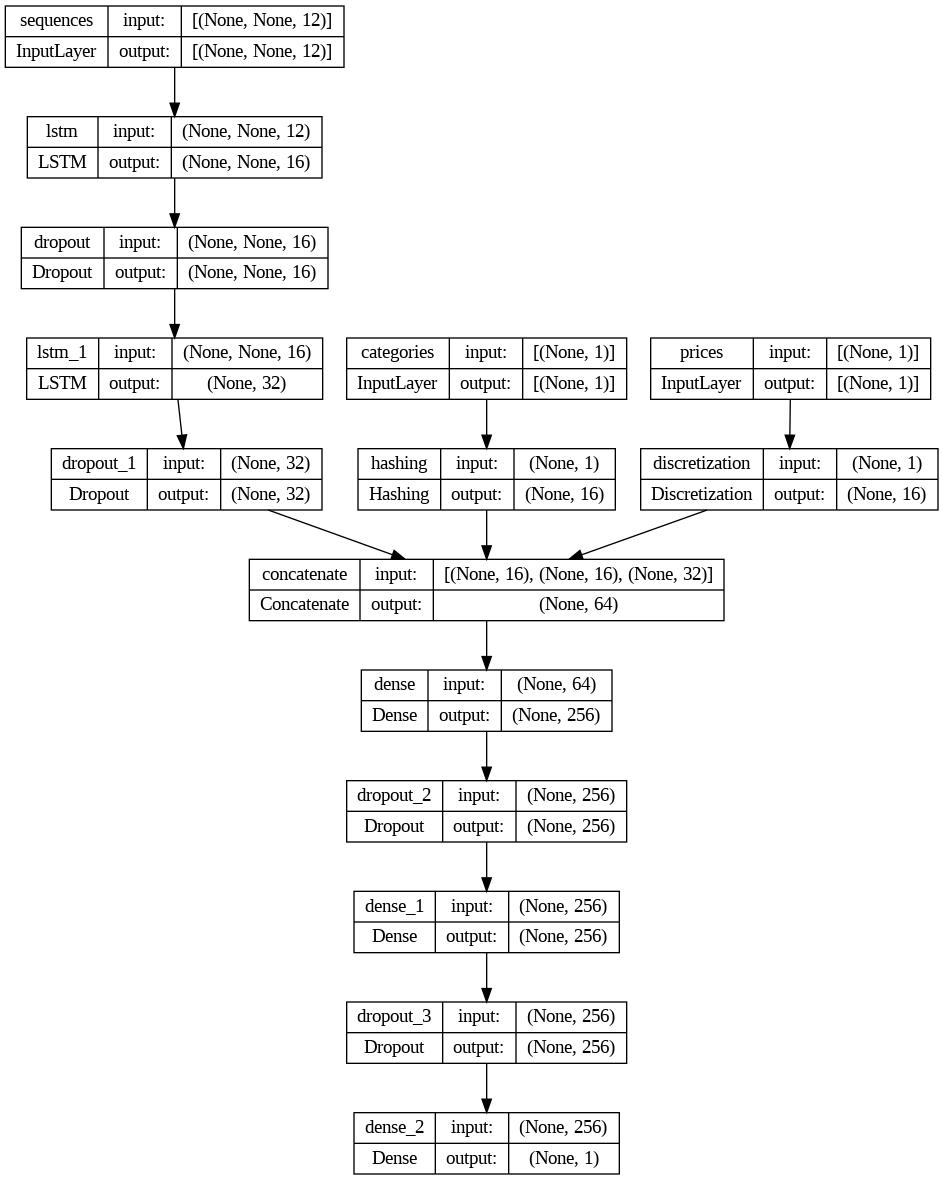

In [ ]:
category_input = keras.layers.Input(shape=(1,), name='categories', dtype='int64')

x = keras.layers.Hashing(num_bins=16, output_mode='one_hot')(category_input)

price_input = keras.Input(shape=(1,), name='prices')

discretization = keras.layers.Discretization(num_bins=16, output_mode='one_hot')
discretization.adapt(training_samples['prices'])

y = discretization(price_input)

sequence_input = keras.Input(shape=(None,12,), name='sequences')

z = keras.layers.LSTM(16, return_sequences=True)(sequence_input)
z = keras.layers.Dropout(0.2)(z)

z = keras.layers.LSTM(32, return_sequences=False)(z)
z = keras.layers.Dropout(0.2)(z)

w = keras.layers.Concatenate()([x,y,z])

w = keras.layers.Dense(256, activation='relu')(w)
w = keras.layers.Dropout(0.2)(w)

w = keras.layers.Dense(256, activation='relu')(w)
w = keras.layers.Dropout(0.2)(w)

pred = keras.layers.Dense(1, activation='relu')(w)

model = keras.Model(
	inputs=[category_input,price_input,sequence_input],
	outputs=pred
)

model.summary()
keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True
)

In [ ]:
model.compile(
	optimizer='adam',
	loss='mse'
)

early_stopping = keras.callbacks.EarlyStopping(
	patience=4,
	monitor='loss',
	min_delta=1e-3,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
	patience=4,
	monitor='loss',
	factor=0.1
)

batch_size = 32

history = model.fit(
	x=training_samples,
	y=training_targets,
	batch_size=batch_size,
	epochs=64,
	validation_data=(validation_samples, validation_targets),
	callbacks=[early_stopping, reduce_lr]
)

Epoch 1/64
10604/10604 [==============================] - 83s 7ms/step - loss: 18.9504 - val_loss: 7.1688 - lr: 0.0010
Epoch 2/64
10604/10604 [==============================] - 76s 7ms/step - loss: 18.9504 - val_loss: 7.1688 - lr: 0.0010
Epoch 3/64
10604/10604 [==============================] - 78s 7ms/step - loss: 18.9504 - val_loss: 7.1688 - lr: 0.0010
Epoch 4/64
10604/10604 [==============================] - 76s 7ms/step - loss: 18.9504 - val_loss: 7.1688 - lr: 0.0010
Epoch 5/64
10604/10604 [==============================] - 76s 7ms/step - loss: 18.9504 - val_loss: 7.1688 - lr: 0.0010


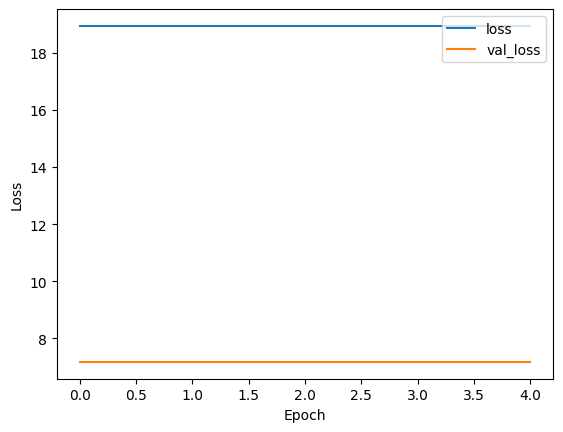

In [ ]:
def make_plot(loss, val_loss):
	fig, ax = plt.subplots()
	ax.plot(loss, label='loss')
	ax.plot(val_loss, label='val_loss')
	ax.set_xlabel('Epoch')
	ax.set_ylabel('Loss')
	ax.legend(loc='upper right')
	plt.show()

make_plot(history.history['loss'], history.history['val_loss'])

We see that our model fit the data optimally within the first epoch and training stopped early. Let's try a model with fewer hidden layers.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequences (InputLayer)      [(None, None, 12)]           0         []                            
                                                                                                  
 categories (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 prices (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 16)                   1856      ['sequences[0][0]']           
                                                                                            

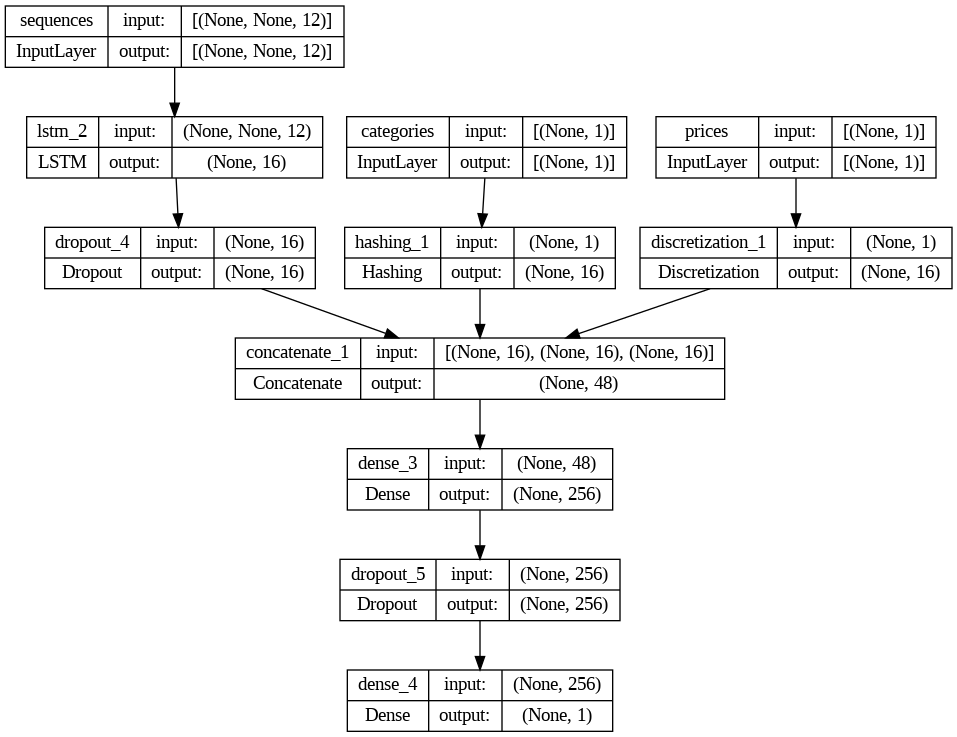

In [ ]:
category_input = keras.layers.Input(shape=(1,), name='categories', dtype='int64')

x = keras.layers.Hashing(num_bins=16, output_mode='one_hot')(category_input)

price_input = keras.Input(shape=(1,), name='prices')

discretization = keras.layers.Discretization(num_bins=16, output_mode='one_hot')
discretization.adapt(training_samples['prices'])

y = discretization(price_input)

sequence_input = keras.Input(shape=(None,12,), name='sequences')

z = keras.layers.LSTM(16, return_sequences=False)(sequence_input)
z = keras.layers.Dropout(0.2)(z)

w = keras.layers.Concatenate()([x,y,z])

w = keras.layers.Dense(256, activation='relu')(w)
w = keras.layers.Dropout(0.2)(w)

pred = keras.layers.Dense(1, activation='relu')(w)

model = keras.Model(
	inputs=[category_input,price_input,sequence_input],
	outputs=pred
)

model.summary()
keras.utils.plot_model(model,to_file='model.png',show_shapes=True)

In [ ]:
model.compile(
	optimizer='adam',
	loss='mse'
)

history = model.fit(
	x=training_samples,
	y=training_targets,
	batch_size=batch_size,
	epochs=64,
	validation_data=(validation_samples, validation_targets),
	callbacks=[early_stopping, reduce_lr]
)

Epoch 1/64
10604/10604 [==============================] - 54s 5ms/step - loss: 17.9572 - val_loss: 4.9736 - lr: 0.0010
Epoch 2/64
10604/10604 [==============================] - 51s 5ms/step - loss: 17.2999 - val_loss: 4.8358 - lr: 0.0010
Epoch 3/64
10604/10604 [==============================] - 52s 5ms/step - loss: 17.5306 - val_loss: 4.1142 - lr: 0.0010
Epoch 4/64
10604/10604 [==============================] - 51s 5ms/step - loss: 17.0285 - val_loss: 3.9920 - lr: 0.0010
Epoch 5/64
10604/10604 [==============================] - 52s 5ms/step - loss: 17.5213 - val_loss: 3.8494 - lr: 0.0010
Epoch 6/64
10604/10604 [==============================] - 52s 5ms/step - loss: 16.9570 - val_loss: 3.8976 - lr: 0.0010
Epoch 7/64
10604/10604 [==============================] - 52s 5ms/step - loss: 16.6945 - val_loss: 3.1069 - lr: 0.0010
Epoch 8/64
10604/10604 [==============================] - 51s 5ms/step - loss: 16.4830 - val_loss: 3.9050 - lr: 0.0010
Epoch 9/64
10604/10604 [========================

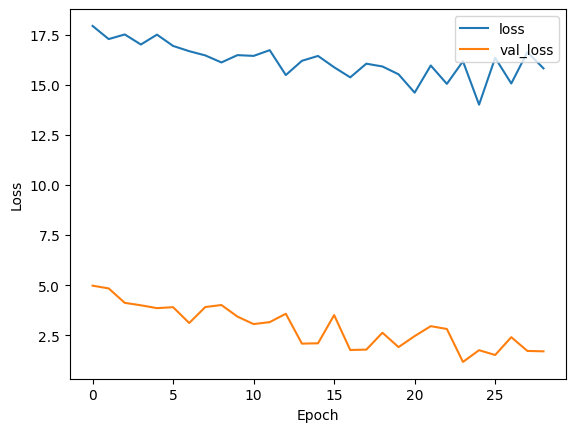

In [ ]:
make_plot(history.history['loss'], history.history['val_loss'])

Let's save the best model, and continue training with more patience.

In [ ]:
try:
	os.mkdir('callbacks')
except: FileExistsError

ckpt = keras.callbacks.ModelCheckpoint(
	'callbacks',
	monitor='loss',
	save_best_only = True
)

early_stopping = keras.callbacks.EarlyStopping(
	patience=8,
	monitor='loss',
	min_delta=1e-3
)

history_continued = model.fit(
	x=training_samples,
	y=training_targets,
	batch_size=batch_size,
	epochs=64,
	validation_data=(validation_samples, validation_targets),
	callbacks=[ckpt, early_stopping, reduce_lr]
)

Epoch 1/64
10604/10604 [==============================] - 55s 5ms/step - loss: 14.8013 - val_loss: 1.5740 - lr: 1.0000e-04
Epoch 2/64
10604/10604 [==============================] - 56s 5ms/step - loss: 14.7171 - val_loss: 1.4132 - lr: 1.0000e-04
Epoch 3/64
10604/10604 [==============================] - 52s 5ms/step - loss: 15.7658 - val_loss: 1.0508 - lr: 1.0000e-04
Epoch 4/64
10604/10604 [==============================] - 51s 5ms/step - loss: 14.8527 - val_loss: 1.1031 - lr: 1.0000e-04
Epoch 5/64
10604/10604 [==============================] - 54s 5ms/step - loss: 13.7366 - val_loss: 1.0045 - lr: 1.0000e-04
Epoch 6/64
10604/10604 [==============================] - 51s 5ms/step - loss: 14.7859 - val_loss: 1.0203 - lr: 1.0000e-04
Epoch 7/64
10604/10604 [==============================] - 51s 5ms/step - loss: 15.5187 - val_loss: 1.0880 - lr: 1.0000e-04
Epoch 8/64
10604/10604 [==============================] - 51s 5ms/step - loss: 15.1685 - val_loss: 1.0799 - lr: 1.0000e-04
Epoch 9/64
10604

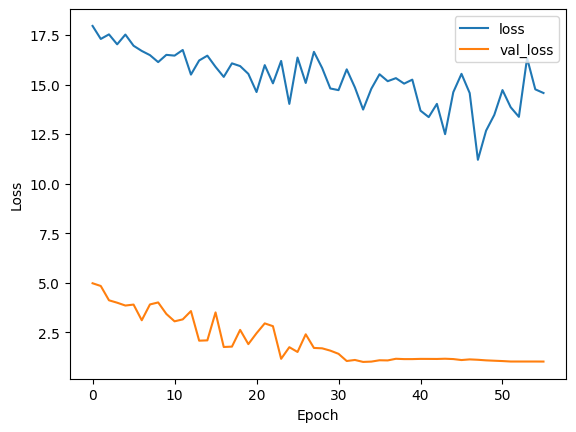

In [ ]:
make_plot(
	history.history['loss'] + history_continued.history['loss'],
	history.history['val_loss'] + history_continued.history['val_loss']
)

In [ ]:
model.load_weights('callbacks')
model.evaluate(test_samples, test_targets)

1326/1326 [==============================] - 4s 3ms/step - loss: 1.1723


1.1723142862319946

Let's compare our model to a more heuristic approach to forecasting sales. Suppose we take the average number of items sold for each month over every sample in our training samples as the prediction of the number of items sold next month.

In [ ]:
monthly_avgs = np.mean(training_samples['sequences'], axis=(0,1))
# since we are trying to predict the number of items sold in October, we are
# use the 9th entry in monthly_avgs
loss = keras.losses.mean_squared_error(test_targets, monthly_avgs[9])
print(f'Mean Squared Error: {loss}')

Mean Squared Error: 2.0202781944741255


This shows our model is more predictive than our heuristic approach. Let's try another another heuristic approach. Suppose we take the average number of items sold every sample in our training samples as the prediction of the number of items sold next month.

In [ ]:
monthly_avg = np.mean(training_samples['sequences'], axis=(0,1,2))
loss = keras.losses.mean_squared_error(test_targets, monthly_avg)
print(f'Mean Squared Error: {loss}')

Mean Squared Error: 2.0190658959804306


Again, this shows our model is more predictive than our heuristic approach. Let's try one last heuristic approach. Suppose we take last months number of items sold as the prediction of the number of items sold next month.

In [ ]:
last_item_cnt = test_samples['sequences'][:,-1,:]
last_item_cnt = np.mean(last_item_cnt, axis=1)
loss = keras.losses.mean_squared_error(test_targets, last_item_cnt)
print(f'Mean Squared Error: {loss}')

Mean Squared Error: 2.339757267818829
